In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sample_random_coordinate(grid_size):
    return np.random.randint(0, grid_size, size=2)

### Methods for Ising model (conditional probability calculation)

In [3]:
def conditional_prob_ising(beta, neighbor_sum):    
    # The probability for x_i = +1 is:
    # P(x_i = +1 | neighbors) = exp(beta * neighbor_sum) / Z
    # where Z = exp(beta * neighbor_sum) + exp(-beta * neighbor_sum)
    energy_plus = beta * neighbor_sum
    
    # Using the formula from the paper:
    prob_plus = np.exp(energy_plus) / (2 * np.cosh(beta * neighbor_sum))
    
    return prob_plus

In [4]:
def sample_ising_cell(beta, neighbour_sum):
    p = conditional_prob_ising(beta, neighbour_sum)
    # Sample +1 with probability p, -1 with probability 1-p
    return 1 if np.random.random() < p else -1

In [5]:
def get_neighbour_sum(canvas, grid_size, coord):
    x = coord[0]
    y = coord[1]

    #considering periodic conditions
    top    = canvas[(x-1) % grid_size, y]
    bottom = canvas[(x+1) % grid_size, y]
    left   = canvas[x, (y-1) % grid_size]
    right  = canvas[x, (y+1) % grid_size]
    
    return top + bottom + left + right

In [6]:
# new approach
def sample_ising_model(grid_size, beta, sweeps=100):
    canvas = np.random.choice([-1, 1], size=(grid_size, grid_size))
    coords = [(i, j) for i in range(grid_size) for j in range(grid_size)]
    
    for _ in range(sweeps):
        np.random.shuffle(coords)
        for x, y in coords:
            neighbor_sum = get_neighbour_sum(canvas, grid_size, (x, y))
            canvas[x, y] = sample_ising_cell(beta, neighbor_sum)
            
    return canvas


In [7]:
# def sample_ising_model(grid_size, beta):
#     #canvas = np.zeros((grid_size,grid_size))

#     canvas = np.random.choice([-1, 1], size=(grid_size, grid_size))

#     for i in range(0,100000):
    
#         coord = sample_random_coordinate(grid_size)
#         neighbour_sum = get_neighbour_sum(canvas, grid_size, coord)
        
#         canvas[coord[0], coord[1]] = sample_ising_cell(beta, neighbour_sum)

#     return canvas

In [8]:
def plot_ising(canvas, beta):
    plt.figure()
    plt.imshow(canvas)
    plt.colorbar()
    plt.title(f'Ising Model Sample (β={beta})')
    plt.show()

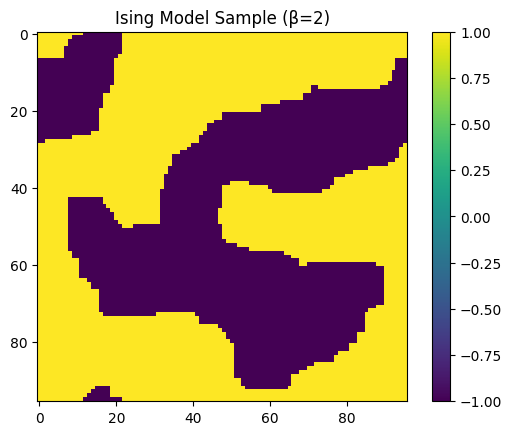

In [9]:
beta = 2
out = sample_ising_model(96, beta)
plot_ising(out, beta)

## Methods for Guass-Markov Random Field

## Energy Function
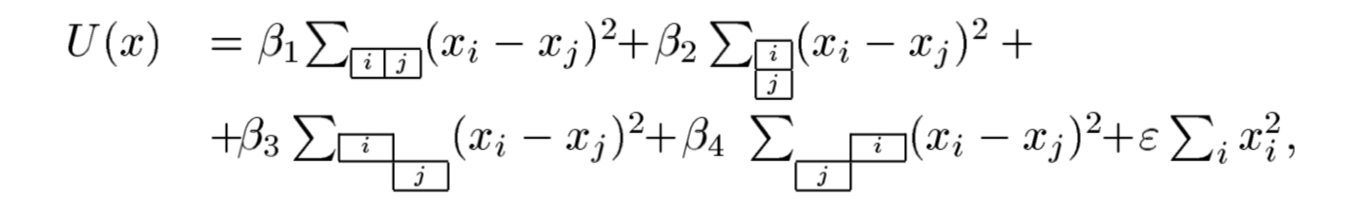

### Gibbs Sampling

$\left(X_i \mid X_{\mathrm{n}(i)}=x_{\mathrm{n}(i)}\right) \sim \mathcal{N}\left(\frac{\sum_{j \in \mathrm{n}(i)} \beta_{i j} x_j}{\varepsilon+8 \bar{\beta}},(2 \varepsilon+16 \bar{\beta})^{-1}\right)$

$\bar{\beta}=\frac{\beta_1+\beta_2+\beta_3+\beta_4}{4}$ 

source : Perez, Patrick. Markov random fields and images. Vol. 469. IRISA, 1998.

In [38]:
def get_neighbour_weighted_sum(canvas, grid_size, coord, betas):
    """
        We need to look at the neighbours of x,y (coord). Here we consider the second-order neighbourhood system
    """
    # current coordinates
    x = coord[0]
    y = coord[1]

    #beta 2
    top    = canvas[(x-1) % grid_size, y]*betas[1]
    bottom = canvas[(x+1) % grid_size, y]*betas[1]

    #beta 1
    left   = canvas[x, (y-1) % grid_size]*betas[0]
    right  = canvas[x, (y+1) % grid_size]*betas[0]
    
    #beta 3 (main diagonal)
    md1 = canvas[(x-1) % grid_size, (y-1) % grid_size]*betas[2]
    md2 = canvas[(x+1) % grid_size, (y+1) % grid_size]*betas[2]

    #beta 4 (off diagonal)
    od1 = canvas[(x-1) % grid_size, (y+1) % grid_size]*betas[3]
    od2 = canvas[(x+1) % grid_size, (y-1) % grid_size]*betas[3]
    

    return top + bottom + left + right + md1 + md2 + od1 + od2

def compute_conditional_parameters(canvas, grid_size, coord, betas, epsilon):
    b_bar = betas.mean()
    
    mean     = get_neighbour_weighted_sum(canvas, grid_size, coord, betas) / (epsilon + 8*b_bar)
    variance = 1/(2*epsilon  + 16*b_bar)
    return mean, variance

def sample_gaussian_cell(mean, variance):
    return np.random.normal(mean, np.sqrt(variance))

In [48]:
def sample_gmrf(grid_size, betas, epsilon, sweeps=100):
    # Initialize canvas with random continuous values
    canvas = np.random.randn(grid_size, grid_size)

    
    coords = [(i, j) for i in range(grid_size) for j in range(grid_size)]
    
    for _ in range(sweeps):
        np.random.shuffle(coords)
        
        for x, y in coords:
            mean, variance = compute_conditional_parameters(canvas, grid_size, (x,y), betas, epsilon)
            canvas[x, y] = sample_gaussian_cell(mean, variance)
            
    return canvas

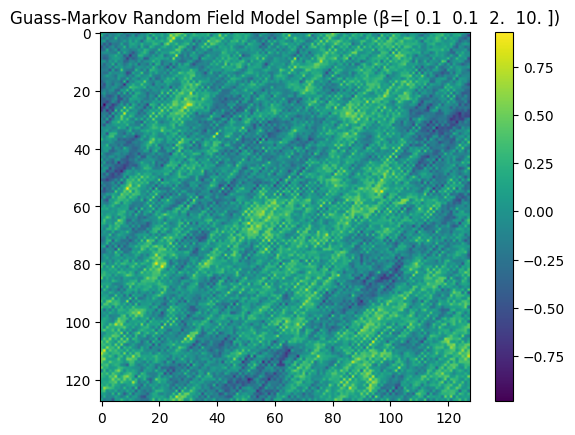

In [51]:
betas = np.array([0.1,0.1,2,10])
epsilon = 0.001

out = sample_gmrf(128, betas, epsilon)
plt.imshow(out)
plt.colorbar()
plt.title(f'Guass-Markov Random Field Model Sample (β={betas})')
plt.show()